# Web Stable Diffusion

This project brings stable diffusion models to web browsers. **Everything runs inside the browser with no server support.** To our knowledge, this is the world’s first stable diffusion completely running on the browser. This notebook is a walk-through on the entire pipeline, including how to import the stable diffusion models from Hugging Face and PyTorch, how to optimize and build the model locally, and how to deploy it to native GPU runtime and WebGPU runtime. Now let’s get started.

![workflow](site/img/fig/workflow.svg)

## Install packages

To import and build the model, we first need to install the on-going development of TVM Unity and other dependencies with the following pip command.  

We import necessary packages and set up the artifact directory.

In [1]:
from platform import system

import tvm
from tvm import relax
from tvm.relax.frontend.torch import dynamo_capture_subgraphs
from tvm.relax.frontend.torch import from_fx
from tvm.script import relax as R

import torch
from torch import fx

from web_stable_diffusion import trace
from web_stable_diffusion import utils

torch_dev_key = "cpu"

if system() == "Darwin":
    target = tvm.target.Target("apple/m1-gpu")
    device = tvm.metal()
else:
    target = tvm.target.Target("cuda" if has_gpu else "llvm")
    device = tvm.cuda() if has_gpu else tvm.cpu()

In [2]:
!mkdir -p dist

## Import stable diffusion models

With necessary packages imported, the first step is to import the stable diffusion PyTorch models into TVM. A standard text-to-image stable diffusion pipeline consists of four stages:
* A text tokenizer which converts the input text prompts to tokens.
* A text encoder (CLIP) which encodes the tokenized text prompts to text embeddings.
* A denoising model (UNet) which denoises a random initial latents for a certain number of steps, guided by the encoded text.
* An image decoder (VAE) which decodes the final latents to an image.


![pipeline](site/img/fig/pipeline.svg)

We shall import these models from PyTorch to TVM. As in Web Stable Diffusion we leverage the [wasm port](https://blog.mithrilsecurity.io/porting-tokenizers-to-wasm/) of the Hugging Face [tokenizers library](https://github.com/huggingface/tokenizers), we only need to import the rest three models: CLIP, UNet and VAE.

PyTorch provides [TorchDynamo](https://pytorch.org/tutorials/intermediate/dynamo_tutorial.html) that can capture the computational graph of a torch model and represent the graph in [Torch FX](https://pytorch.org/docs/stable/fx.html), torch’s graph-level intermediate representation (IR) of a model. TorchDynamo and FX are the tools we leverage. More specifically, we first use TorchDynamo to capture the model’s execution into an FX GraphModule, and then translate the FX GraphModule to a Relax function -- the graph-level IR of TVM Unity.

Compared with building and deploying the stable diffusion model to, for eaxmple, local CUDA backend, building and deploying the model to web with WebGPU runtime is special, mostly because of the difference of runtime environment:

**Web runtime has no Python (let alone PyTorch, NumPy). We can only leverage JavaScript for model deployment on web.**

Considering this major difference, we will need to _simplify the runtime stable diffusion pipeline (written in JavaScript) as much as possible_, and maximize the number of tasks in the build stage, ahead of the web model deployment. Our workflow demonstrates this principal in the two following aspects:
1. capture more computation to TVM’s IRModule,
2. separate models’ weights from the IRModule.

### 1. Capture more computation to TVM’s IRModule

Because we do not have PyTorch in web runtime, it is necessary to cover those additional operations in our IRModule as well. There are two different approaches to the same goal. Both are very simple:
1. implement the operations manually with existing Relax infrastructure, or
2. write a wrapper `torch.nn.Module` which both contains the ML model and the appending/prepending operations.

In our practice, we adopt both approaches. For some operations we use wrapper `nn.Module`, while for others we write the operation manually. Let’s walk through each of them.

#### ①. The CLIP text encoder

In the entire pipeline, the text encoder is used twice: one for the prompt and the other one for the negative prompt. Since it is next to the tokenization (which we do not import) and is followed by the concatenation of both prompts’ embeddings, the encoder is a standalone phase. Therefore, we use an `nn.Module` to wrap the single CLIP forward.

Relax has provided a helper function `dynamo_capture_subgraphs`, which uses TorchDynamo to capture the computational graph, and translate the captured FX GraphModule to a Relax function. In stable diffusion, the maximum length of text prompts is 77. So the input to the CLIP model has length 77. We create a random input as the simulation of tokenized text prompt, and pass it to the wrapper for TorchDynamo capture.

In [3]:
def clip_to_text_embeddings(pipe) -> tvm.IRModule:
    # Define the wrapper torch.nn.Module for CLIP.
    class CLIPModelWrapper(torch.nn.Module):
        def __init__(self, clip):
            super().__init__()
            self.clip = clip

        def forward(self, text_input_ids):
            text_embeddings = self.clip(text_input_ids)[0]
            return text_embeddings

    clip = pipe.text_encoder
    clip_to_text_embeddings = CLIPModelWrapper(clip)

    # Create random input (77 is the maximum length).
    text_input_ids = torch.rand((1, 77)).to(torch.int32)
    # Capture CLIP's computational graph.
    mod = dynamo_capture_subgraphs(
        clip_to_text_embeddings.forward,
        text_input_ids,
        keep_params_as_input=True,
    )
    assert len(mod.functions) == 1

    return tvm.IRModule({"clip": mod["subgraph_0"]})

#### ②. The embedding concatenation

This stage concatenates the embeddings of both prompts, and is followed by the huge UNet iteration. It is also standalone, and here we choose to implement the concatenation by hand.

In [4]:
def concat_embeddings() -> tvm.IRModule:
    bb = relax.BlockBuilder()
    cond_embeddings = relax.Var("cond_embeddings", R.Tensor([1, 77, 768], "float32"))
    uncond_embeddings = relax.Var(
        "uncond_embeddings", R.Tensor([1, 77, 768], "float32")
    )
    with bb.function("concat_embeddings", [cond_embeddings, uncond_embeddings]):
        res = bb.emit(
            relax.op.concat([cond_embeddings, uncond_embeddings], axis=0)
        )
        bb.emit_func_output(res)
    return bb.get()

#### ③. Latent concat + UNet + classifier-free guidance

The third stage is the first part of the UNet loop body. It is mostly the UNet forward, while before the UNet forward there is a step of latent concatenation, and after UNet forward, one step of [classifier-free guidance](https://github.com/huggingface/diffusers/blob/79eb3d07d07a2dada172c5958d6fca478c860f16/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L674-L677) will be performed to force the generation to better match the prompt potentially. Since the latent concatenation and the guidance are immediately before/after the UNet forward which we always have to import whatever, we use a wrapper `nn.Module` to import all of them.

In [5]:
def unet_latents_to_noise_pred(pipe, device_str: str) -> tvm.IRModule:
    class UNetModelWrapper(torch.nn.Module):
        def __init__(self, unet):
            super().__init__()
            self.unet = unet
            # Default guidance scale factor in stable diffusion.
            self.guidance_scale = 7.5

        def forward(self, latents, timestep_tensor, text_embeddings):
            # Latent concatenation.
            latent_model_input = torch.cat([latents] * 2, dim=0)
            # UNet forward.
            noise_pred = self.unet(latent_model_input, timestep_tensor, text_embeddings)
            # Classifier-free guidance.
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + self.guidance_scale * (
                noise_pred_text - noise_pred_uncond
            )
            return noise_pred

    unet = utils.get_unet(pipe, device_str)
    unet_to_noise_pred = UNetModelWrapper(unet)
    graph = fx.symbolic_trace(unet_to_noise_pred)
    mod = from_fx(
        graph,
        [((1, 4, 64, 64), "float32"), ((), "int32"), ((2, 77, 768), "float32")],
        keep_params_as_input=True,
    )
    return tvm.IRModule({"unet": mod["main"]})

#### ④. Scheduler step

The scheduler step stage is the other part of the UNet iteration, and is very important for updating the latents towards the denoising direction. There are many kinds of different schedulers, with each having (possibly) largely different implementation. Here we use the multi-step DPM solver scheduler.

One feature of schedulers is that schedulers usually maintain a list of history UNet output, and the scheduler step operation takes the maintained history as input internally. Since the step operation is history dependent, we are not able to combine the scheduler step together with the previous UNet part, and have to implement it separately. Because the scheduler step is also standalone mostly, we implement it by hand.

In [6]:
def dpm_solver_multistep_scheduler_steps() -> tvm.IRModule:
    bb = relax.BlockBuilder()

    # convert_model_output, the first function in multi-step DPM solver.
    sample = relax.Var("sample", R.Tensor((1, 4, 64, 64), "float32"))
    model_output = relax.Var("model_output", R.Tensor((1, 4, 64, 64), "float32"))
    alpha = relax.Var(f"alpha", R.Tensor((), "float32"))
    sigma = relax.Var(f"sigma", R.Tensor((), "float32"))
    with bb.function(
        "dpm_solver_multistep_scheduler_convert_model_output",
        [sample, model_output, alpha, sigma],
    ):
        converted_model_output = bb.emit(
            (sample - sigma * model_output) / alpha, "converted_model_output"
        )
        bb.emit_func_output(converted_model_output)

    # step, the second function.
    sample = relax.Var("sample", R.Tensor((1, 4, 64, 64), "float32"))
    model_output = relax.Var("model_output", R.Tensor((1, 4, 64, 64), "float32"))
    last_model_output = relax.Var(
        "last_model_output", R.Tensor((1, 4, 64, 64), "float32")
    )
    consts = [relax.Var(f"c{i}", R.Tensor((), "float32")) for i in range(3)]

    with bb.function(
        "dpm_solver_multistep_scheduler_step",
        [sample, model_output, last_model_output, *consts],
    ):
        prev_sample = bb.emit(
            consts[0] * sample
            - consts[1] * model_output
            - consts[2] * (model_output - last_model_output),
            "prev_sample",
        )
        bb.emit_func_output(prev_sample)

    return bb.get()

#### ⑤. VAE + image normalization

The last but one stage is the VAE step followed by an image normalization, which normalizes the value range from `[-1, 1]` to integers in `[0, 255]`. For the same reason as ③, we use a wrapper `nn.Module`.

In [7]:
def vae_to_image(pipe) -> tvm.IRModule:
    class VAEModelWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, latents):
            # Scale the latents so that it can be decoded by VAE.
            latents = 1 / 0.13025 * latents
            # VAE decode
            # z = self.vae.post_quant_conv(latents)
            image = self.vae.decode(latents, return_dict=False)[0]
            # Image normalization
            image = (image / 2 + 0.5).clamp(min=0, max=1)
            image = (image.permute(0, 2, 3, 1) * 255).round()
            return image

    vae = utils.get_vae(pipe, "1.5")
    vae_to_image = VAEModelWrapper(vae)

    graph = fx.symbolic_trace(vae_to_image)
    mod = from_fx(
        graph,
        [((1, 4, 64, 64), "float32")],
        keep_params_as_input=True,
    )
    return tvm.IRModule({"vae": mod["main"]})

#### ⑥. Image conversion to RGBA

To display the image, we need to convert the image to RGBA mode that can be directly rendered by the web runtime. This conversion requires dtype `uint32`, which PyTorch doesn’t support. Therefore, we are unable to combine this stage with the previous one, and need to implement it by hand with Relax.

In [8]:
def image_to_rgba() -> tvm.IRModule:
    from tvm import te

    def f_image_to_rgba(A):
        def fcompute(y, x):
            return (
                A[0, y, x, 0].astype("uint32")
                | (A[0, y, x, 1].astype("uint32") << 8)
                | (A[0, y, x, 2].astype("uint32") << 16)
                | tvm.tir.const(255 << 24, "uint32")
            )

        return te.compute((512, 512), fcompute, name="image_to_rgba")

    bb = relax.BlockBuilder()
    x = relax.Var("x", R.Tensor([1, 512, 512, 3], "float32"))
    with bb.function("image_to_rgba", [x]):
        image = bb.emit(
            bb.call_te(f_image_to_rgba, x, primfunc_name_hint="tir_image_to_rgba")
        )
        bb.emit_func_output(image)
    return bb.get()

#### Combine every piece together

We have described how we import every part of the stable diffusion pipeline into Relax. Now we can combine every of them together:

In [9]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("SG161222/Realistic_Vision_V5.1_noVAE")
clip = clip_to_text_embeddings(pipe)
unet = unet_latents_to_noise_pred(pipe, torch_dev_key)
vae = vae_to_image(pipe)
concat_embeddings = concat_embeddings()
image_to_rgba = image_to_rgba()
schedulers = [
    dpm_solver_multistep_scheduler_steps(),
    trace.PNDMScheduler.scheduler_steps()
]

mod: tvm.IRModule = utils.merge_irmodules(
    clip,
    unet,
    vae,
    concat_embeddings,
    image_to_rgba,
    *schedulers,
)

/Users/guoyaoli/ENTER/envs/sdxl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Separate models’ weights from the IRModule

After the steps above, we get an IRModule which contains the computational graph of the stable diffusion model, as well as the weights of the model. To reduce the size of the built artifact so that it can be universally deployed everywhere (including the web), we separate models’ weights from the IRModule we get. For a weight tensor, we use a placeholder to represent it in the IRModule, instead of letting it reside in the IRModule as a constant tensor. We will save the separated weights to the disk later. At the beginning of the deployment, we will load these weights from disk to memory.

The separation is implemented as function `relax.frontend.detach_params`.

In [10]:
mod, params = relax.frontend.detach_params(mod)

We can try to print out the entire IRModule via 
```python
mod.show()
```
to see the models and other functions we have imported in the IRModule. The output will be thousands of lines long, so we do not run it live here. If you try it out, the printed output should look in the following way:
```python
# from tvm.script import ir as I
# from tvm.script import relax as R

@I.ir_module
class Module:
    @R.function
    def clip(
        inp_0: R.Tensor((1, 77), dtype="int32"),
        self_clip_text_model_embeddings_position_embedding_weight: R.Tensor((77, 768), dtype="float32"),
        self_clip_text_model_embeddings_token_embedding_weight: R.Tensor((49408, 768), dtype="float32"),
        ...
    ) -> R.Tensor((1, 77, 768), dtype="float32"):
        R.func_attr({"num_input": 1})
        with R.dataflow():
            lv: R.Tensor((1, 77), dtype="int32") = R.reshape(inp_0, R.shape([1, 77]))
            lv1: R.Tensor((1, 77), dtype="int32") = R.astype(lv, dtype="int32")
            lv2: R.Tensor((77,), dtype="int32") = R.reshape(lv1, R.shape([77]))
            lv3: R.Tensor((77, 768), dtype="float32") = R.take(self_clip_text_model_embeddings_token_embedding_weight, lv2, axis=0)
            lv4: R.Tensor((1, 77, 768), dtype="float32") = R.reshape(lv3, R.shape([1, 77, 768]))
            lv5: R.Tensor((1, 77), dtype="int32") = R.astype(metadata["relax.expr.Constant"][0], dtype="int32")
            lv6: R.Tensor((77,), dtype="int32") = R.reshape(lv5, R.shape([77]))
            lv7: R.Tensor((77, 768), dtype="float32") = R.take(self_clip_text_model_embeddings_position_embedding_weight, lv6, axis=0)
            lv8: R.Tensor((1, 77, 768), dtype="float32") = R.reshape(lv7, R.shape([1, 77, 768]))
            lv9: R.Tensor((1, 77, 768), dtype="float32") = R.add(lv4, lv8)
            ...
```

Instead of printing out the whole IRModule, what we can do is to print out the names of the functions.

In [11]:
def print_relax_funcnames(mod: tvm.IRModule):
    for global_var, func in mod.functions.items():
        if isinstance(func, relax.Function):
            print(global_var.name_hint)
    print()


print_relax_funcnames(mod)

clip
pndm_scheduler_step_1
concat_embeddings
image_to_rgba
vae
pndm_scheduler_step_3
dpm_solver_multistep_scheduler_step
pndm_scheduler_step_0
pndm_scheduler_step_4
pndm_scheduler_step_2
dpm_solver_multistep_scheduler_convert_model_output
unet



We can also print out one of the weight tensors to see what we have captured for model weights.

In [12]:
# Print the first weight parameter of the CLIP model.
params["clip"][0]

<tvm.nd.NDArray shape=(77, 768), cpu(0)>
array([[ 0.00156689,  0.00194168,  0.00016713, ..., -0.00132465,
         0.00070763,  0.00154114],
       [ 0.00407791,  0.00286674,  0.00019097, ...,  0.0009532 ,
         0.00129795, -0.00137329],
       [ 0.00177574,  0.00089645, -0.0011549 , ..., -0.00291634,
        -0.00099277,  0.00261116],
       ...,
       [ 0.02189636,  0.00549698, -0.00985718, ..., -0.00648499,
        -0.00284958,  0.00395203],
       [ 0.01896667,  0.00723648, -0.00776291, ..., -0.00273514,
        -0.00053787,  0.00589371],
       [ 0.03314209,  0.02822876,  0.02874756, ...,  0.01580811,
         0.01037598, -0.0308075 ]], dtype=float32)

By now, we have went through all steps of importing the stable diffusion model to Relax. The above logic of import is implemented in [`web_stable_diffusion/trace/model_trace.py`](https://github.com/mlc-ai/web-stable-diffusion/blob/main/web_stable_diffusion/trace/model_trace.py) and [`web_stable_diffusion/trace/scheduler_trace.py`](https://github.com/mlc-ai/web-stable-diffusion/blob/main/web_stable_diffusion/trace/scheduler_trace.py).

## Optimize the model

So far, we have imported all the desired models and functions in the stable diffusion into an IRModule of TVM. This section is about how we transform and optimize the IRModule we get.

### Default optimization pipeline in Relax

Relax provides a default optimization pipeline for a given IRModule. This pipeline mainly includes the constant folding optimization and the kernel fusion optimization.

In [13]:
# Apply the default optimization pipeline.
mod = relax.pipeline.get_pipeline()(mod)

[00:08:25] /Users/guoyaoli/tvm_work/tvm/include/tvm/topi/transform.h:1126: Warning: Fast mode segfaults when there are out-of-bounds indices. Make sure input indices are in bound
[00:08:25] /Users/guoyaoli/tvm_work/tvm/include/tvm/topi/transform.h:1126: Warning: Fast mode segfaults when there are out-of-bounds indices. Make sure input indices are in bound


After the kernel fusion optimization in the default optimization pipeline, there will be some unused elements in the IRModule. Here we do a clean up on the IRModule.

In [14]:
model_names = ["clip", "unet", "vae"]
scheduler_func_names = [
    name
    for name in trace.DPMSolverMultistepScheduler.scheduler_steps_func_names()
]
entry_funcs = (
    model_names + scheduler_func_names + ["image_to_rgba", "concat_embeddings"]
)

# Clean up unused parts of the IRModule.
mod = relax.transform.DeadCodeElimination(entry_funcs)(mod)

### Lift computation on weight parameters

Since the stable diffusion models’ weight parameter are always constants at the time of deployment, we can finish the computation around the weight parameters in ahead of deployment. To this end, we separate such computation from the original functions to standalone functions in the IRModule, so that such computation can be done in the build stage. The separation is implemented as the `LiftTransformParams` pass.

In [15]:
mod = relax.transform.LiftTransformParams()(mod)
mod = relax.transform.BundleModelParams()(mod)

We can see that after applying this pass, three new functions are inside the IRModule. Their names are ended with `"_transform_params"`, which means the functions are in the purpose of computing models’ weight parameters and will be built and executed in the build stage.

In [16]:
for global_var, function in mod.functions.items():
    if isinstance(function, relax.Function):
        if global_var.name_hint.endswith("_transform_params"):
            print(
                global_var.name_hint,
                f' # <=== This is the weight parameter computation function for "{global_var.name_hint[:-17]}"',
            )
        else:
            print(global_var.name_hint)

pndm_scheduler_step_3
dpm_solver_multistep_scheduler_convert_model_output
unet_transform_params  # <=== This is the weight parameter computation function for "unet"
pndm_scheduler_step_1
concat_embeddings
pndm_scheduler_step_0
pndm_scheduler_step_2
vae_transform_params  # <=== This is the weight parameter computation function for "vae"
vae
pndm_scheduler_step_4
unet
clip_transform_params  # <=== This is the weight parameter computation function for "clip"
image_to_rgba
clip
dpm_solver_multistep_scheduler_step


### Split the IRModule at build stage and deployment stage

After last subsection, the IRModule now contains functions both for the build stage and deployment stage. Therefore, we need to split the IRModule into two parts.

In [17]:
mod_transform, mod_deploy = utils.split_transform_deploy_mod(
    mod, model_names, entry_funcs
)

Let’s print the Relax function names in the IRModules after split.

In [18]:
print("In IRModule for build stage:")
print_relax_funcnames(mod_transform)

print("In IRModule for deployment stage:")
print_relax_funcnames(mod_deploy)

In IRModule for build stage:
unet_transform_params
vae_transform_params
clip_transform_params

In IRModule for deployment stage:
pndm_scheduler_step_3
dpm_solver_multistep_scheduler_convert_model_output
pndm_scheduler_step_1
concat_embeddings
pndm_scheduler_step_0
pndm_scheduler_step_2
vae
pndm_scheduler_step_4
unet
image_to_rgba
clip
dpm_solver_multistep_scheduler_step



### Prepare for build

We have finished transforming the IRModule. One last step before building the IRModule is to compute and save the all the constants at deployment to our artifact directory. There are two kinds of constants that we need to compute and save:
* the constants of the models’ weight parameters and related computation lifted by pass `LiftTransformParams`, and
* the coefficients used by the stable diffusion schedulers at each UNet iteration.

Compared with computing them in the deployed model, doing the computation in ahead has several benefits:
* it minimizes the workload of the deployed model,
* we can universally and easily deploy our model on platforms without, e.g., Python environment.

In [19]:
# Compute and save the scheduler constants.
trace.compute_save_scheduler_consts(artifact_path="dist")
# Compute and save the models's weight parameters.
new_params = utils.transform_params(mod_transform, params)
utils.save_params(new_params, artifact_path="dist")

Start storing to cache dist/params
[1054/1054] saving clip_195
All finished, 61 total shards committed, record saved to dist/params/ndarray-cache.json
Also saved a bf16 record to dist/params/ndarray-cache-b16.json


All transformation and the final build preparation in this section are contained in the `legalize_and_lift_params` function of `build.py`.

## Build the model

After all preparation for the build stage, in this section we will build the model. The contents of this section is implemented as the `build` function of `build.py`. To build the model outside this notebook, the command is
```shell
python3 build.py
```

### Apply provided kernel optimization database

The IRModule before the build stage contains three kinds of Relax functions:
* Relax functions of ML models (CLIP, UNet and VAE),
* Relax functions of schedulers (scheduler step function), and
* some utility Relax functions (e.g., text embedding concatenation, VAE-output-to-image conversion).

Each of the Relax function calls into many low-level primitive tensor functions. For example, the first scheduler step Relax function of PNDM scheduler is

In [20]:
mod_deploy["dpm_solver_multistep_scheduler_step"].show()

As shown above, this scheduler step Relax function calls into two multiplication functions, one division function and one subtraction function. We can print out the multiplication function to see how the primitive tensor functions look like:

In [21]:
called_gv = mod_deploy["dpm_solver_multistep_scheduler_step"].body.blocks[0].bindings[0].value.args[0]

mod_show = tvm.IRModule({called_gv: mod_deploy[called_gv]})
mod_show.show(black_format=False)


To have decently high performance for all such primitive tensor functions, we have provided a pre-tuned database, which contains the optimization for every primitive tensor functions in the IRModule to build. What we need to do here is simply to apply the database to the IRModule, with the help of function `MetaScheduleApplyDatabase`.

In [22]:
from tvm import meta_schedule as ms

db = ms.database.create(work_dir="log_db")
with target, db, tvm.transform.PassContext(opt_level=3):
    mod_deploy = relax.transform.MetaScheduleApplyDatabase()(mod_deploy)
    mod_deploy = tvm.tir.transform.DefaultGPUSchedule()(mod_deploy)

After applying the database, the multiplication primitive tensor function shown above now becomes:

In [23]:
mod_show = tvm.IRModule({called_gv: mod_deploy[called_gv]})
mod_show.show(black_format=False)

### Build the model

With the database applied in the last subsection, every part of the IRModule is ready to be built. We now use `relax.build` to build the IRModule to the desired backend target, e.g., Metal for Mac M1. `relax.build` returns an executable object, which will be taken and executed by the VirtualMachine of Relax.

In [24]:
ex = relax.build(mod=mod_deploy, target=target)

In [25]:
type(ex)

tvm.relax.vm_build.Executable

We export the executable to disk as a shared library. The exported shared library will be loaded back in the deployment stage.

In [26]:
ex.export_library("dist/stable_diffusion.so")

The build stage right ends here. Let’s recall a bit: after build, the objects we saved to the disk are:
* the shared library, which is the build artifact of the IRModule to deploy,
* the weight parameter constants,
* the scheduler constants.

With merely these parts, we are able to bring and deploy our stable diffusion model to anywhere that supports minimum TVM runtime. This well demonstrates our concept of universal deployment.

Of course, we still need a stable diffusion pipeline script that connects all these parts together and describes the procedure of stable diffusion. We will introduce this in the next section -- deployment.

## Deploy the model locally

This section will demo how we deploy the built model locally with native GPU runtime. The contents of this section is implemented in `deploy.py`. To deploy the model outside this notebook, the command is
```shell
python3 deploy.py
```

### Load the model

The first job of deployment is to load back the model shared library and the constants we saved to disk.

In [27]:
# Load the model weight parameters back.
const_params_dict = utils.load_params(artifact_path="dist", device=device)
# Load the model executable back from the shared library.
ex = tvm.runtime.load_module("dist/stable_diffusion.so")

We create a `relax.VirtualMachine` with the executable object loaded back and the targeted device (Metal/CUDA/CPU).

In [28]:
vm = relax.VirtualMachine(rt_mod=ex, device=device)

The virtual machine provides interfaces to call into the Relax functions in `mod_deploy` above, which we will use later.

### Define the scheduler class

Similar to scheduler classes in Hugging Face diffusers, we also define the scheduler class for stable diffusion runtime. On construction, the scheduler class will load the scheduler constants from the JSON file we saved to the disk at the build stage. The main interface of the scheduler class is the `step` function, which is invoked at the end of each UNet iteration.

We implement the PNDM scheduler, which is the default scheduler of [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5).

In [29]:
import json
import numpy as np

from web_stable_diffusion import runtime


class DPMSolverMultistepScheduler(runtime.Scheduler):
    scheduler_name = "multistep-dpm-solver"

    def __init__(self, artifact_path: str, device) -> None:
        # Load the scheduler constants.
        with open(
            f"{artifact_path}/scheduler_dpm_solver_multistep_consts.json", "r"
        ) as file:
            jsoncontent = file.read()
        scheduler_consts = json.loads(jsoncontent)

        def f_convert(data, dtype):
            return [tvm.nd.array(np.array(t, dtype=dtype), device) for t in data]

        self.timesteps = f_convert(scheduler_consts["timesteps"], "int32")
        self.alpha = f_convert(scheduler_consts["alpha"], "float32")
        self.sigma = f_convert(scheduler_consts["sigma"], "float32")
        self.c0 = f_convert(scheduler_consts["c0"], "float32")
        self.c1 = f_convert(scheduler_consts["c1"], "float32")
        self.c2 = f_convert(scheduler_consts["c2"], "float32")

        # Initialize the model_output history.
        self.last_model_output: tvm.nd.NDArray = tvm.nd.empty(
            (1, 4, 64, 64), "float32", device
        )

    def step(
        self,
        vm: relax.VirtualMachine,
        model_output: tvm.nd.NDArray,
        sample: tvm.nd.NDArray,
        counter: int,
    ) -> tvm.nd.NDArray:
        # Invoke the functions through VM.
        model_output = vm["dpm_solver_multistep_scheduler_convert_model_output"](
            sample, model_output, self.alpha[counter], self.sigma[counter]
        )
        prev_latents = vm["dpm_solver_multistep_scheduler_step"](
            sample,
            model_output,
            self.last_model_output,
            self.c0[counter],
            self.c1[counter],
            self.c2[counter],
        )
        self.last_model_output = model_output
        return prev_latents

### Define the stable diffusion pipeline

We now define the stable diffusion pipeline that connects everything together. The pipeline takes the virtual machine we build, the Hugging Face tokenizer, a scheduler and the model weight parameter constants for construction. The main interface of the pipeline takes a prompt and an optional negative prompt as input, and returns the generated image as output.

In [33]:
from PIL import Image
from tqdm import tqdm
from transformers import CLIPTokenizer


class TVMSDPipeline:
    def __init__(
        self,
        vm: relax.VirtualMachine,
        tokenizer: CLIPTokenizer,
        scheduler: runtime.Scheduler,
        tvm_device,
        param_dict,
    ):
        def wrapper(f, params):
            def wrapped_f(*args):
                return f(*args, params)

            return wrapped_f

        self.vm = vm
        self.clip_to_text_embeddings = wrapper(vm["clip"], param_dict["clip"])
        self.unet_latents_to_noise_pred = wrapper(vm["unet"], param_dict["unet"])
        self.vae_to_image = wrapper(vm["vae"], param_dict["vae"])
        self.concat_embeddings = vm["concat_embeddings"]
        self.image_to_rgba = vm["image_to_rgba"]
        self.tokenizer = tokenizer
        self.scheduler = scheduler
        self.tvm_device = tvm_device
        self.param_dict = param_dict

    def __call__(self, prompt: str, negative_prompt: str = ""):
        # The height and width are fixed to 512.

        # Compute the embeddings for the prompt and negative prompt.
        list_text_embeddings = []
        for text in [negative_prompt, prompt]:
            text = [text]
            # Tokenize the text.
            text_inputs = self.tokenizer(
                text,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,  # 77
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids.to(torch.int32)
            # Clip the text if the length exceeds the maximum allowed length.
            if text_input_ids.shape[-1] > self.tokenizer.model_max_length:
                text_input_ids = text_input_ids[:, : self.tokenizer.model_max_length]

            # Compute text embeddings.
            text_input_ids = tvm.nd.array(text_input_ids.cpu().numpy(), self.tvm_device)
            text_embeddings = self.clip_to_text_embeddings(text_input_ids)
            list_text_embeddings.append(text_embeddings)
        
        # Concatenate the text embeddings.
        text_embeddings = self.concat_embeddings(*list_text_embeddings)

        # Randomly initialize the latents.
        latents = torch.randn(
            (1, 4, 64, 64),
            device="cpu",
            dtype=torch.float32,
        )
        latents = tvm.nd.array(latents.numpy(), self.tvm_device)

        # UNet iteration.
        for i in tqdm(range(len(self.scheduler.timesteps))):
            t = self.scheduler.timesteps[i]
            noise_pred = self.unet_latents_to_noise_pred(latents, t, text_embeddings)
            latents = self.scheduler.step(self.vm, noise_pred, latents, i)

        # VAE decode.
        image = self.vae_to_image(latents)

        # Transform generated image to RGBA mode.
        image = self.image_to_rgba(image)
        return Image.fromarray(image.numpy().view("uint8").reshape(512, 512, 4))

### Run

We are ready to go! Let’s instantiate the pipeline and pass in a real prompt to generate the image.

In [34]:
pipe = TVMSDPipeline(
    vm=vm,
    tokenizer=CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14"),
    scheduler=runtime.DPMSolverMultistepScheduler(artifact_path="dist", device=device),
    tvm_device=device,
    param_dict=const_params_dict,
)

In [35]:
import time

prompt = "high quality, face portrait photo of 30 y.o asian woman, wearing black shirt, serious face, detailed face, skin pores, cinematic shot, dramatic lighting"
neg_prompt = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime:1.4), text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"

start = time.time()
image = pipe(prompt, negative_prompt=neg_prompt)
end = time.time()

print(f"Time elapsed: {end - start} seconds.")

100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Time elapsed: 15.305974960327148 seconds.


We can use `display` to showcase the generated image.

ValueError: Could not save to JPEG for display

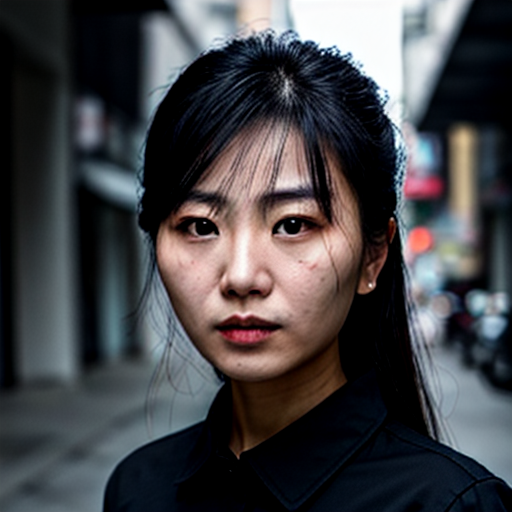

In [36]:
display(image)

## Deploy on web

We have tried to deploy the stable diffusion model with native GPU runtime. Now let’s try to deploy the stable diffusion to web end with WebGPU runtime.

To deploy to web, everything is following the same procedure. Some minor differences are:
* we need a build the model to WebGPU backend, instead of Metal backend,
* we need to implement the stable diffusion pipeline and the scheduler runtime in JavaScript.

Nevertheless, they both have the same spirit as before -- just in another form.

### Install prerequisites

We first install some prerequisite packages.

1. [emscripten](https://emscripten.org). It is an LLVM-based compiler which compiles C/C++ source code to WebAssembly.
    - Follow the [installation instruction](https://emscripten.org/docs/getting_started/downloads.html#installation-instructions-using-the-emsdk-recommended) to install the latest emsdk.
    - Source `emsdk_env.sh` by `source path/to/emsdk_env.sh`, so that `emcc` is reachable from PATH and the command `emcc` works.
2. [Rust](https://www.rust-lang.org/tools/install).
3. [`wasm-pack`](https://rustwasm.github.io/wasm-pack/installer/). It helps build Rust-generated WebAssembly, which used for tokenizer in our case here.
4. Install jekyll by following the [official guides](https://jekyllrb.com/docs/installation/). It is the package we use for website.
5. Install jekyll-remote-theme by command
    ```shell
    gem install jekyll-remote-theme
    ```
6. Install [Chrome Canary](https://www.google.com/chrome/canary/). It is a developer version of Chrome that enables the use of WebGPU.

We can run the following commands to verify that we have installed them properly and can found these programs.

In [ ]:
!emcc

In [ ]:
!jekyll

In [ ]:
!wasm-pack

After verifying the functionality of these commands, we run `scripts/prep_deps.sh` to prepare all the necessary dependencies for the web build.

In [ ]:
%%bash
export TVM_HOME=3rdparty/tvm
./scripts/prep_deps.sh

The execution `scripts/prep_deps.sh` is expected to end with
```
Copy /path/to/tvm/web/dist/tvmjs.bundle.js to dist
Copy /path/to/tvm/web/dist/wasm/tvmjs_runtime.wasi.js to dist
```

### Build the model to WebGPU backend

We now build the model to WebGPU backend and export the executable to disk in the WebAssembly file format.

In the previous section on building the model to native GPU backend, the command was
```shell
python3 build.py
```

To build to WebGPU backend, we still use `build.py`, just with an argument specifying the target:

In [ ]:
%%bash
export TVM_HOME=3rdparty/tvm
python3 build.py --target webgpu

### Set up the website

The last thing to do is setting up the site by running the following command in a terminal session:
```shell
./scripts/local_deploy_site.sh
```

Once the website is set up, open `localhost:8888/` in Chrome Canary to try out the demo on your local machine!

---

_Remark: don’t forget to use_
```shell
/Applications/Google\ Chrome\ Canary.app/Contents/MacOS/Google\ Chrome\ Canary --enable-dawn-features=disable_robustness
```
_to launch Chrome Canary to turn off the robustness check from Chrome._